<h1> Vorbereitung

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [345]:
# DFs einlesen
df_training_all_features = pd.read_parquet(
    "../data/processed/df_training_all_features.parquet"
)
df_test_all_features = pd.read_parquet(
    "../data/processed/df_test_all_features.parquet"
)

Funktion definieren, die Modellprediction evaluiert und in ein Dataframe schreibt

In [346]:
# Globales DataFrame zur Speicherung der Ergebnisse
results_df = pd.DataFrame(columns=["Durchlauf", "Modell", "Accuracy", "F1 Score"])

def log_model_performance(durchlauf_name: str, model_name: str, y_pred, y_test):
    """
    Berechnet Accuracy und F1-Score anhand von y_test und y_pred und
    fügt die Ergebnisse dem globalen DataFrame results_df hinzu.
    
    Parameter:
      - durchlauf_name: Name des Durchlaufs (String)
      - model_name: Name des verwendeten Modells (String)
      - y_pred: Vorhersagen des Modells
      - y_test: Wahre Zielwerte
      
    Gibt zurück:
      - Das aktualisierte DataFrame mit den Spalten "Durchlauf", "Modell", "Accuracy" und "F1 Score"
    """
    global results_df
    # Berechnung der Metriken
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Neuen Eintrag als DataFrame erstellen
    new_row = pd.DataFrame({
        "Durchlauf": [durchlauf_name],
        "Modell": [model_name],
        "Accuracy": [acc],
        "F1 Score": [f1]
    })
    
    # Ergebnisse zum globalen DataFrame hinzufügen
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    return results_df

<h1> Marios Teil (Ensembe Methoden)


<h1> Gradient Boosting: XGBOOST

In [347]:
# Split für Trainingsdaten
X = df_training_all_features.drop('User of latest model', axis=1)
y = df_training_all_features['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h3> XGBoost Baseline

In [348]:
# Umwandeln der Spalten in den kategorischen Typ:
categorical_cols = ["Sex", "Ctry", "Town", "Goal of Training", 
                    "Preferred Training Daytime", "Subscription Type", "Synchronisation"]

for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

model = XGBClassifier(
    objective="binary:logistic", 
    random_state=42,
    tree_method="hist",         # Notwendig für den experimentellen Support
    enable_categorical=True     # Experimenteller Parameter zur Nutzung von Pandas' category-Daten
)
model.fit(X_train, y_train)

# Vorhersagen auf dem Testset machen
y_pred = model.predict(X_test)


df_results = log_model_performance(model_name= "XGBoost", durchlauf_name="Baseline", y_pred = y_pred, y_test = y_test)
df_results


C:\Users\mario\AppData\Local\Temp\ipykernel_20368\1598733018.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377


<h2> Feature Selection

<h3> Feature Importance

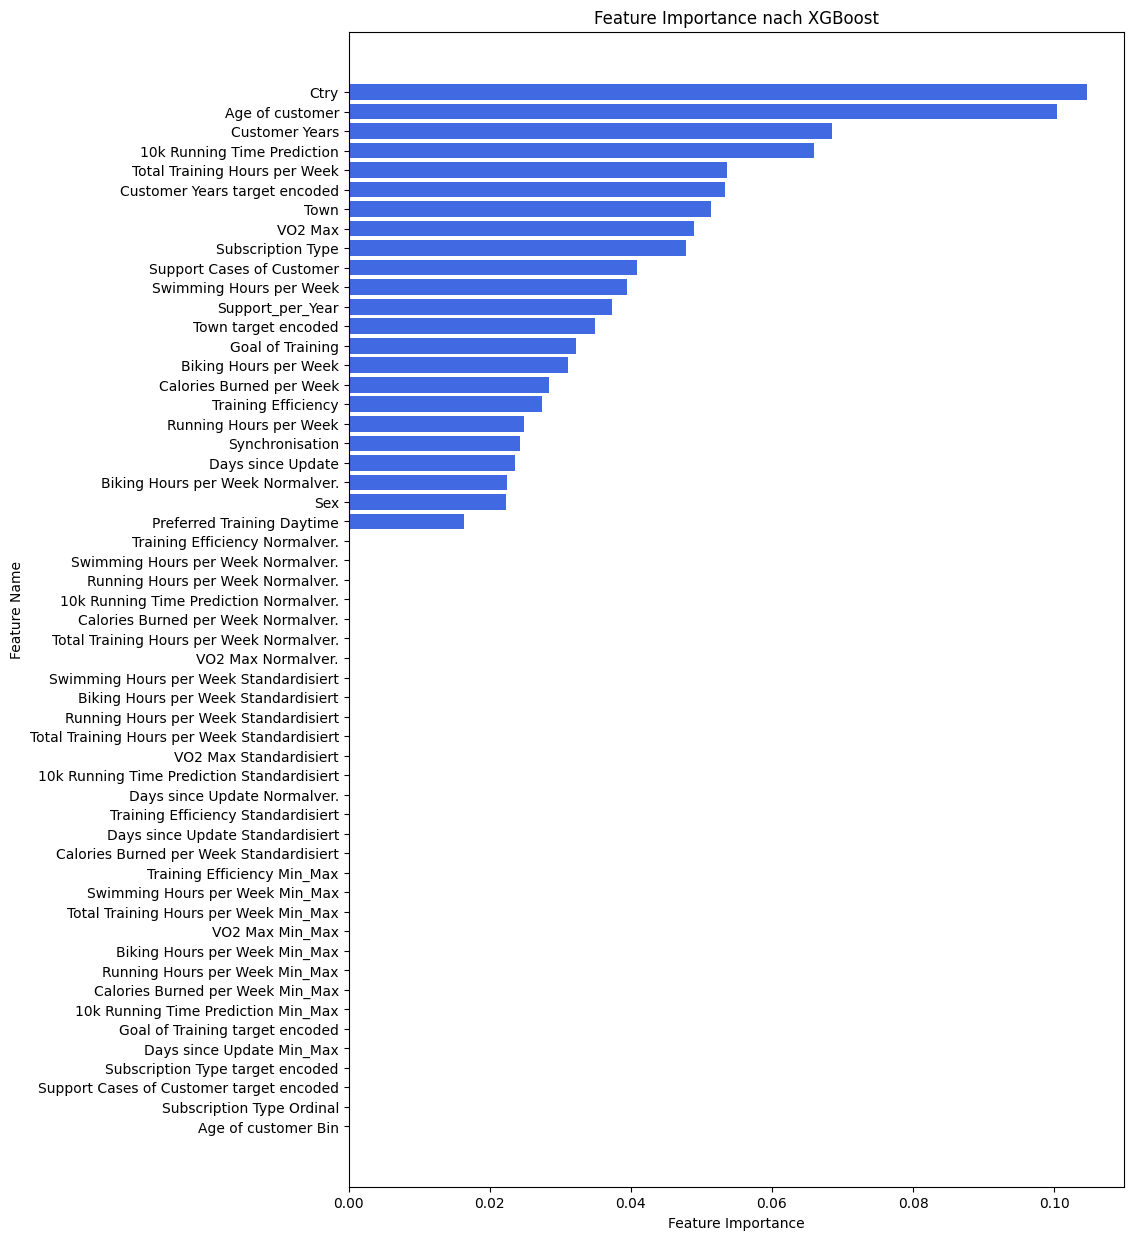

In [349]:
# Feature-Wichtigkeiten abrufen
importances = model.feature_importances_
feature_names = X_train.columns

# In DataFrame umwandeln und sortieren
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Visualisieren
plt.figure(figsize=(10,15))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="royalblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance nach XGBoost")
plt.gca().invert_yaxis()
plt.show()

Wie man sieht, gibt es einige Features, deren Featureimportance Null beträgt. Diese werden im nächsten Schrill entfernt und das Modell neu trainiert.

In [350]:
# Umwandeln der Spalten in den kategorischen Typ:
categorical_cols = ["Sex", "Ctry", "Town", "Goal of Training", 
                    "Preferred Training Daytime", "Subscription Type", "Synchronisation"]

# Begrenzung auf Features mit Feature Importance > 0
X_train = X_train[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]]
X_test = X_test[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]]

for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

model = XGBClassifier(
    objective="binary:logistic", 
    random_state=42,
    tree_method="hist",         # Notwendig für den experimentellen Support
    enable_categorical=True     # Experimenteller Parameter zur Nutzung von Pandas' category-Daten
)
model.fit(X_train, y_train)

# Vorhersagen auf dem Testset machen
y_pred = model.predict(X_test)


df_results = log_model_performance(model_name= "XGBoost", durchlauf_name="Featureimportance > 0 (new Baseline)", y_pred = y_pred, y_test = y_test)
df_results


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774


<!-- Die Entfernung der Features ohne Featureimportance hat das Modell verbessert.
Daher wird dieser Stand als neue Baseline für zukünftige Vergleiche genutzt.
Nun werden die numerischen Features mit dem ANOVA F-Score analysiert: -->

Das Entfernen der Features mit einer Featureimportance von Null hat das Modell verbessert.

Daher wird dieses Modell als neue Baseline für künftige Vergleiche genutzt.

Nun werden die numerischen Werte mit dem Anova F-Score analysiert:

<h3> Anova F-Score (für numerische Features)

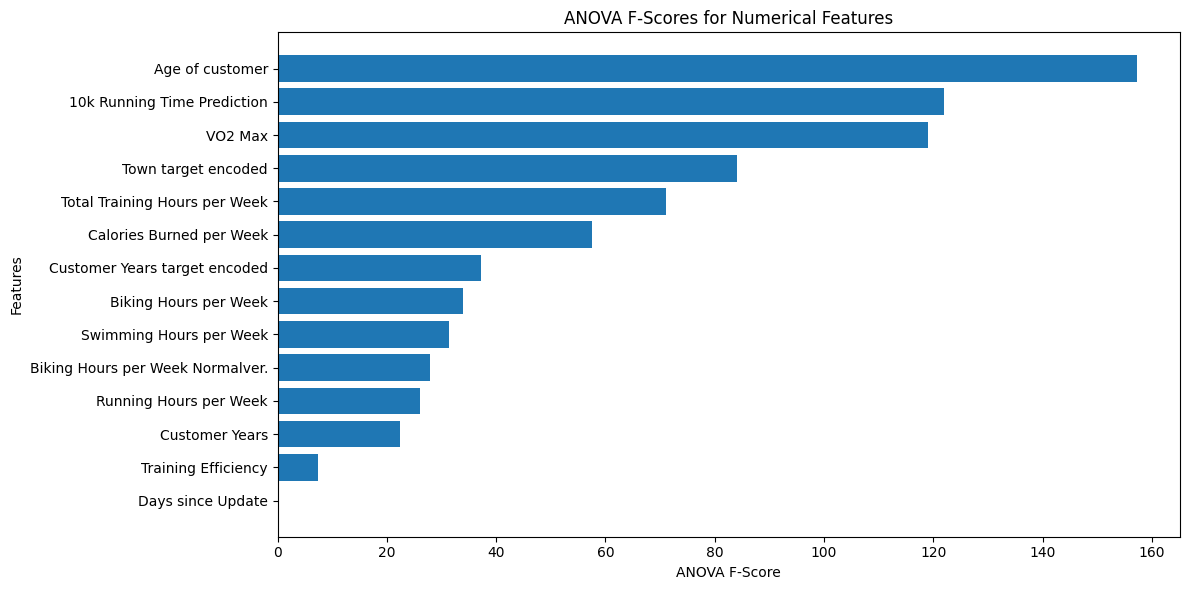

In [351]:
# Get numerical features that have non-zero importance
numerical_features = feature_importance_df[
    (feature_importance_df['Importance'] > 0) & 
    (~feature_importance_df['Feature'].isin(['Sex', 'Ctry', 'Town', 'Goal of Training', 
                                           'Preferred Training Daytime', 'Subscription Type', 
                                           'Synchronisation', "Support Cases of Customer", "Support_per_Year"]))
]['Feature'].values

# Calculate F-scores
X_numerical = X_train[numerical_features]
f_scores, p_values = f_classif(X_numerical, y_train)

# Create DataFrame with results
anova_results = pd.DataFrame({
    'Feature': numerical_features,
    'F_Score': f_scores,
    'p_value': p_values
})

# Sort by F-score
anova_results = anova_results.sort_values('F_Score', ascending=False)

# Create visualization
plt.figure(figsize=(12, 6))
plt.barh(anova_results['Feature'], anova_results['F_Score'])
plt.xlabel('ANOVA F-Score')
plt.ylabel('Features')
plt.title('ANOVA F-Scores for Numerical Features')
plt.gca().invert_yaxis()  # Invert y-axis to show highest scores at top
plt.tight_layout()
plt.show()

Interpretation des ANOVA F-Scores
- Hoher F-Score: Ein hoher Wert deutet darauf hin, dass das Feature einen großen Unterschied zwischen den Gruppen (Zielklassen) macht. Das Feature ist also wahrscheinlich wichtig für das Modell.
- Niedriger F-Score: Ein niedriger Wert deutet darauf hin, dass das Feature nicht wirklich zwischen den Gruppen unterscheidet und somit weniger informativ ist.

- Days since update hat einen Anova F-Score von 0 und war auch bei der Featureimportance nicht besonders wichtig -> wird entfernt
- Training Efficiency hat einen niedrigen Anova F-Score und eine relativ niedrige Featureimportance -> wird entfernt
- Customer Years hat einen recht geringen Anova F-Score, aber eine hohe Featureimportance (der geringe Anova F-Score entsteht wahrscheinlich, weil es nur 12 einizartige Werte in diesem Feature gibt) -> wird nicht entfernt

In [352]:
# Umwandeln der Spalten in den kategorischen Typ:
categorical_cols = ["Sex", "Ctry", "Town", "Goal of Training", 
                    "Preferred Training Daytime", "Subscription Type", "Synchronisation"]

# Begrenzung auf Features mit Feature Importance > 0
X_train_temp = X_train[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]].drop(columns=["Days since Update", "Training Efficiency"], axis=1)
X_test_temp = X_test[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]].drop(columns=["Days since Update", "Training Efficiency"], axis=1)

for col in categorical_cols:
    X_train_temp[col] = X_train_temp[col].astype("category")
    X_test_temp[col] = X_test_temp[col].astype("category")

model = XGBClassifier(
    objective="binary:logistic", 
    random_state=42,
    tree_method="hist",         # Notwendig für den experimentellen Support
    enable_categorical=True     # Experimenteller Parameter zur Nutzung von Pandas' category-Daten
)
model.fit(X_train_temp, y_train)

# Vorhersagen auf dem Testset machen
y_pred = model.predict(X_test_temp)


df_results = log_model_performance(model_name= "XGBoost", durchlauf_name="Anova F-Score", y_pred = y_pred, y_test = y_test)
df_results


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351


Das entfernen der beiden Features mit dem niedrigen Anova F-Score hat das Modell verschelchtert. Daher werden diese Features in Zukunft weiterhin für das Training benutzt.

<h3> Chi-Quadrat Test für kategorische Features

C:\Users\mario\AppData\Local\Temp\ipykernel_20368\3670157174.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chi_square_results = pd.concat([chi_square_results, new_row], ignore_index=True)


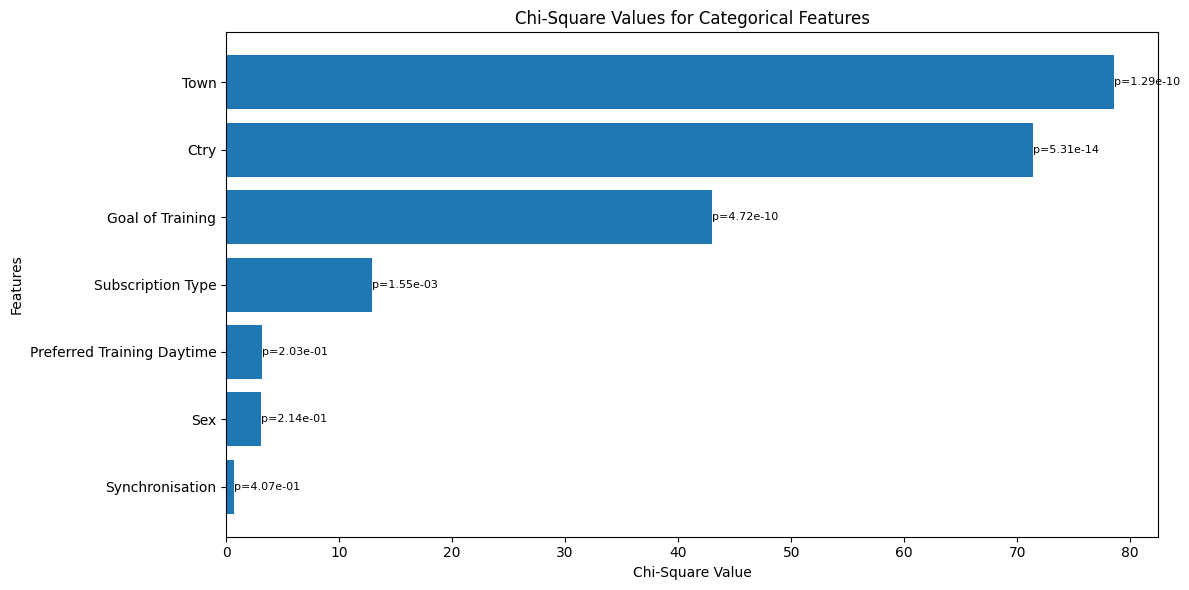

In [353]:
from scipy.stats import chi2_contingency

# Get only categorical columns from X_test
categorical_cols = ["Sex", "Ctry", "Town", "Goal of Training", 
                   "Preferred Training Daytime", "Subscription Type", "Synchronisation"]
X_test_categorical = X_test[categorical_cols]

# Initialize a DataFrame to store chi-square results
chi_square_results = pd.DataFrame(columns=['Feature', 'Chi-Square', 'p-value'])

# Get categorical features from X_test_categorical
for feature in categorical_cols:
    # Create contingency table
    contingency = pd.crosstab(X_train[feature], y_train)
    
    # Perform chi-square test
    chi2, p_value, _, _ = chi2_contingency(contingency)
    
    # Add results to DataFrame
    new_row = pd.DataFrame({
        'Feature': [feature],
        'Chi-Square': [chi2],
        'p-value': [p_value]
    })
    chi_square_results = pd.concat([chi_square_results, new_row], ignore_index=True)

# Sort by Chi-Square value
chi_square_results = chi_square_results.sort_values('Chi-Square', ascending=False)

# Create visualization
plt.figure(figsize=(12, 6))
bars = plt.barh(chi_square_results['Feature'], chi_square_results['Chi-Square'])
plt.xlabel('Chi-Square Value')
plt.ylabel('Features')
plt.title('Chi-Square Values for Categorical Features')

# Add p-values to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    p_value = chi_square_results.iloc[i]['p-value']
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'p={p_value:.2e}', 
             va='center',
             fontsize=8)

plt.gca().invert_yaxis()  # Invert y-axis to show highest scores at top
plt.tight_layout()
plt.show()

- Ein hoher Chi-Square-Wert bedeutet, dass es eine starke Abhängigkeit zwischen dem Feature und der Zielvariable gibt → Das Feature ist potenziell wichtig für die Klassifikation.
- Ein niedriger Chi-Square-Wert bedeutet, dass das Feature kaum oder keinen Zusammenhang mit der Zielvariable hat → Wenig Einfluss auf die Klassifikation.
p-Wert ergänzt die Analyse:
- p < 0.05 → Statistisch signifikanter Zusammenhang (Feature relevant)
- p ≥ 0.05 → Kein signifikanter Zusammenhang (Feature wahrscheinlich unwichtig)

Synchronisation, Sex und Preferred Training Daytime haben ein geringen Chi-Square-Value und einen p-Wert von über 0.05 und werden daher entfernt

In [354]:
# Umwandeln der Spalten in den kategorischen Typ:
categorical_cols = ["Ctry", "Town", "Goal of Training", "Subscription Type"]

# Begrenzung auf Features mit Feature Importance > 0
X_train_temp = X_train[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]].drop(columns=["Preferred Training Daytime"], axis=1)
X_test_temp = X_test[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]].drop(columns=["Preferred Training Daytime"], axis=1)

for col in categorical_cols:
    X_train_temp[col] = X_train_temp[col].astype("category")
    X_test_temp[col] = X_test_temp[col].astype("category")

model = XGBClassifier(
    objective="binary:logistic", 
    random_state=42,
    tree_method="hist",
    enable_categorical=True
)
model.fit(X_train_temp, y_train)

# Vorhersagen auf dem Testset machen
y_pred = model.predict(X_test_temp)

df_results = log_model_performance(model_name= "XGBoost", durchlauf_name="Chi Square", y_pred = y_pred, y_test = y_test)
df_results

,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500


Das Entfernen der Features mit einem geringen Chi-Squared Wert hat das Modell verschlechtert (auch das entfernen einzelner Features). Daher werden diese Features beibehalten.

Grund für die Verschlechtrerung könnte sein, dass es eine nicht-lineare Abhängigkeit gibt (Chi-Square-Test erfasst nur lineare abhängigkeiten.)

<h3> Featureselection Fazit

Der Analyse nach zu Urteilen sind die besten Features alle Features, deren Feature_importance nicht Null ist!


<h2> Hyperparameter Tuning

Das Hyperparameter Tuning wird mit RandomizedSerchCV (zufällige Suche anhand gegebener Parameter) durchgeführt.
Das Hyperparameter Tuning ist rechenintensiv und dauert etwas.

In [355]:
# Split für Trainingsdaten
X = df_training_all_features.drop('User of latest model', axis=1)
y = df_training_all_features['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [356]:
# Kategorische Spalten definieren und konvertieren
categorical_cols = [
    "Sex", "Ctry", "Town", "Goal of Training", 
    "Preferred Training Daytime", "Subscription Type", "Synchronisation"
]

# Features filtern
X_train = X_train[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]]
X_test = X_test[feature_importance_df[feature_importance_df["Importance"] > 0]["Feature"]]

# Spalten in kategorischen Typ umwandeln
for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# Parameterverteilungen für die Suche
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11],
    'learning_rate': loguniform(1e-3, 0.3),
    'n_estimators': [50, 100, 200, 300],
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'min_child_weight': [1, 2, 3, 4]
}

# Baseline-Modell mit kategorischem Support
model = XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    tree_method="hist",
    enable_categorical=True,
    eval_metric="logloss"
)

# Randomized Search mit 50 Iterationen und 5-Fold-CV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Hyperparameter-Suche auf Trainingsdaten durchführen
random_search.fit(X_train, y_train)

# Bestes Modell ausgeben
best_params = random_search.best_params_
print("Beste Parameter:", best_params)

best_model = random_search.best_estimator_

# Vorhersagen mit dem optimierten Modell
y_pred_tuned = best_model.predict(X_test)

# Modellperformance berechnen
df_results = log_model_performance(
    model_name="XGBoost", 
    durchlauf_name="Hyperparameter-Tuning", 
    y_pred=y_pred_tuned, 
    y_test=y_test
)

df_results

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Beste Parameter: {'colsample_bytree': np.float64(0.9401003442596488), 'gamma': np.float64(0.2898698384767031), 'learning_rate': np.float64(0.02657147977395315), 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': np.float64(0.7784979664116332)}


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500
4,Hyperparameter-Tuning,XGBoost,0.769231,0.709677


Das Hyperparameter Tuning hat das Modell weiter verbessert!
Die folgenden Parameter haben eine Accuracy von 0.784615 erzielt:

 Beste Parameter: {'colsample_bytree': np.float64(0.6553459284957908), 'gamma': np.float64(0.21227756046053303), 'learning_rate': np.float64(0.044604646959992715), 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': np.float64(0.6630244246750918)} 

<h1> Adaptive Boosting: AdaBoost </h1>
Ein Ensemble-Modell kombiniert mehrere schwache Modelle (z. B. Decision Trees) zu einem stärkeren Modell, um die Vorhersage zu verbessern.

In [357]:
# Split für Trainingsdaten
X = df_training_all_features.drop('User of latest model', axis=1)
y = df_training_all_features['User of latest model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h3> Adaboost Baseline

In [358]:
# Select only numerical columns for X
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_num = X_train[numerical_cols]
X_test_num = X_test[numerical_cols]

# Create and train AdaBoost classifier
model = AdaBoostClassifier(random_state=42)
model.fit(X_train_num, y_train)

# Make predictions
y_pred = model.predict(X_test_num)

# Log performance
df_results = log_model_performance(
    model_name="AdaBoost", 
    durchlauf_name="Baseline", 
    y_pred=y_pred, 
    y_test=y_test
)

df_results

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500
4,Hyperparameter-Tuning,XGBoost,0.769231,0.709677
5,Baseline,AdaBoost,0.728205,0.653595


<h2> Feature Selection

<h3> Feature importance

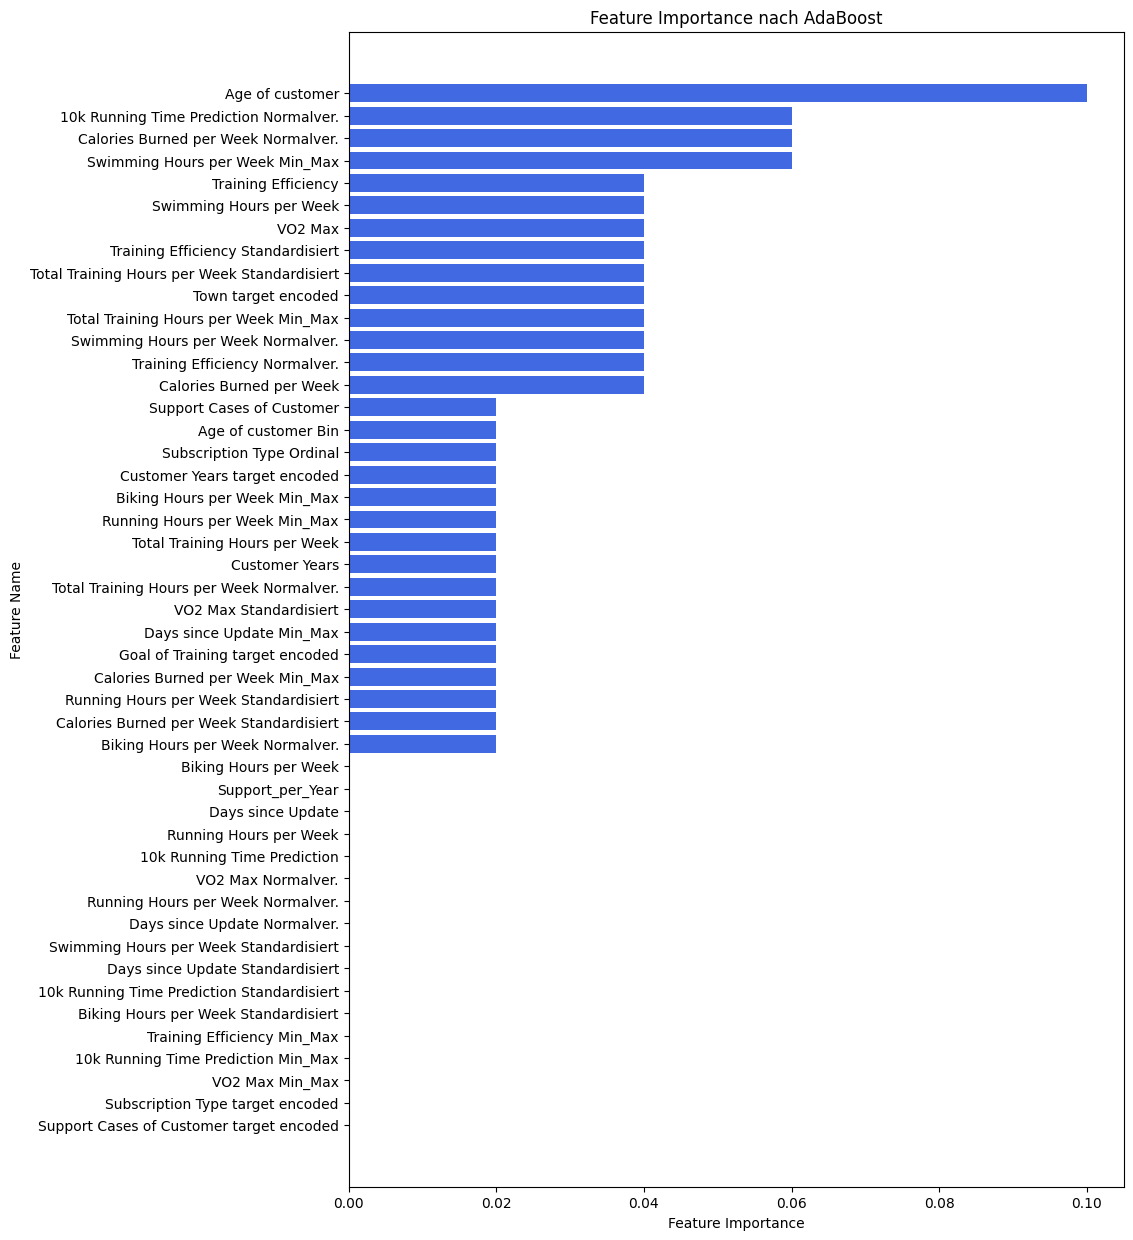

In [360]:
# Get feature importances from AdaBoost model
importances = model.feature_importances_
feature_names = X_train_num.columns

# Create DataFrame with feature importances and sort by importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(10,15))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance nach AdaBoost')
plt.gca().invert_yaxis()
plt.show()

In [363]:
# Get features with non-zero importance from feature importance DataFrame
non_zero_features = feature_importance_df[feature_importance_df['Importance'] > 0]['Feature'].values

# Create new training and test sets with selected features
X_train_selected = X_train[non_zero_features]
X_test_selected = X_test[non_zero_features]

# Create and train AdaBoost classifier
model = AdaBoostClassifier(random_state=42)
model.fit(X_train_selected, y_train)

# Make predictions
y_pred = model.predict(X_test_selected)

# Log performance
df_results = log_model_performance(
    model_name="AdaBoost", 
    durchlauf_name="Featureimportance > 0", 
    y_pred=y_pred, 
    y_test=y_test
)

df_results

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500
4,Hyperparameter-Tuning,XGBoost,0.769231,0.709677
5,Baseline,AdaBoost,0.728205,0.653595
6,After Feature Selection,AdaBoost,0.728205,0.653595
7,Featureimportance > 0,AdaBoost,0.728205,0.653595


Die Entfernung der Features mit einer Featureimportance von Null hat das Modell nicht verbessert.

<h3> Anova F-Score

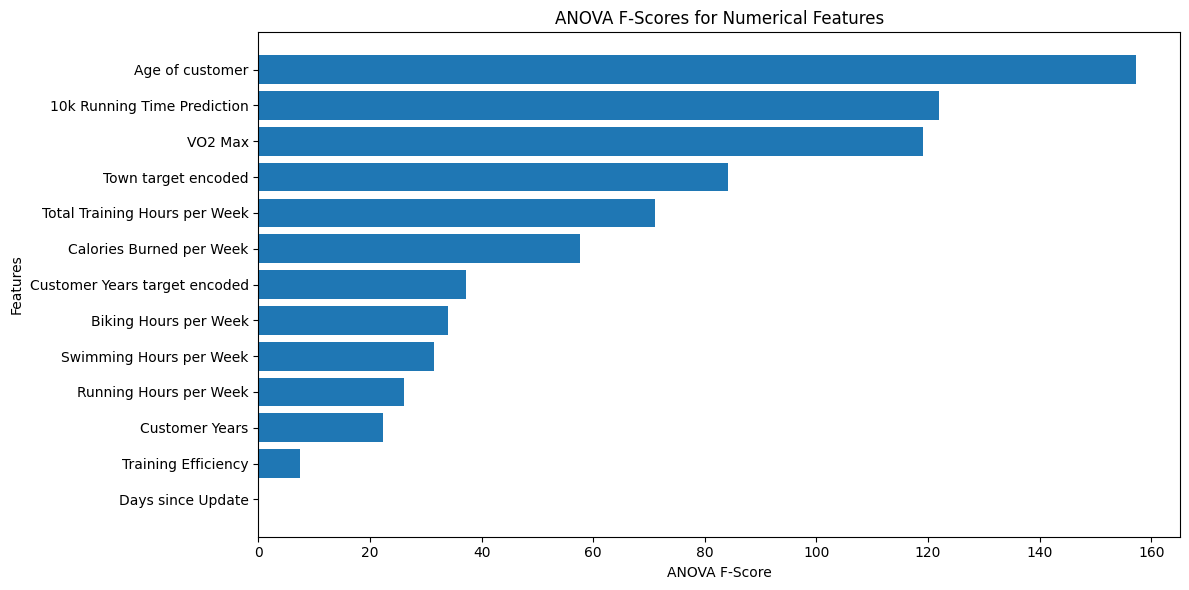

In [364]:
# Get numerical features from X_train
numerical_features = ['Age of customer', 'Customer Years', '10k Running Time Prediction',
                     'Total Training Hours per Week', 'Customer Years target encoded',
                     'VO2 Max', 'Swimming Hours per Week', 'Town target encoded',
                     'Biking Hours per Week', 'Calories Burned per Week',
                     'Training Efficiency', 'Running Hours per Week',
                     'Days since Update']

# Calculate F-scores
X_numerical = X_train[numerical_features]
f_scores, p_values = f_classif(X_numerical, y_train)

# Create DataFrame with results
anova_results = pd.DataFrame({
    'Feature': numerical_features,
    'F_Score': f_scores,
    'p_value': p_values
})

# Sort by F-score
anova_results = anova_results.sort_values('F_Score', ascending=False)

# Create visualization
plt.figure(figsize=(12, 6))
plt.barh(anova_results['Feature'], anova_results['F_Score'])
plt.xlabel('ANOVA F-Score')
plt.ylabel('Features')
plt.title('ANOVA F-Scores for Numerical Features')
plt.gca().invert_yaxis()  # Invert y-axis to show highest scores at top
plt.tight_layout()
plt.show()

Days since Update hat einen Anova F-Score von 0 und Training Efficiency hat einen sehr geringen Wert, daher werden diese beiden Features entfernt:

In [369]:
# Select only numerical columns for X
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_num = X_train[numerical_cols].drop(columns=["Days since Update", "Training Efficiency"], axis=1)
X_test_num = X_test[numerical_cols].drop(columns=["Days since Update", "Training Efficiency"], axis=1)

# Create and train AdaBoost classifier
model = AdaBoostClassifier(random_state=42)
model.fit(X_train_num, y_train)

# Make predictions
y_pred = model.predict(X_test_num)

# Log performance
df_results = log_model_performance(
    model_name="AdaBoost", 
    durchlauf_name="Anova F-Score", 
    y_pred=y_pred, 
    y_test=y_test
)

df_results

c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500
4,Hyperparameter-Tuning,XGBoost,0.769231,0.709677
5,Baseline,AdaBoost,0.728205,0.653595
6,After Feature Selection,AdaBoost,0.728205,0.653595
7,Featureimportance > 0,AdaBoost,0.728205,0.653595
8,Baseline,AdaBoost,0.728205,0.653595
9,Baseline,AdaBoost,0.707692,0.636943


Das entfernen der beiden Features hat das Modell nicht verbessert, daher werden die Features beibehalten.

<h3> Featureselection Fazit </h3>
Das Baseline Model konnte durch Feature Selection nicht weiter optimiert werden. Daher sind für den Adaboost Algorithmus alle numerischen Features geeignet.

<h2> Hyperparameter Tuning

In [373]:
# Definiere den Base Estimator (Decision Tree)
base_estimator = DecisionTreeClassifier()

# Hyperparameter-Suchraum
tuned_parameters = {
    'n_estimators': np.arange(50, 500, 50),  # Anzahl der schwachen Learner
    'learning_rate': np.logspace(-3, 1, 10),  # Lernrate
    'estimator': [
        DecisionTreeClassifier(max_depth=d) for d in range(1, 6)  # Tiefe des Base Estimators
    ]
}

# AdaBoost-Modell erstellen
adaboost = AdaBoostClassifier(random_state=42)

# RandomizedSearchCV für schnelleres Tuning
random_search = RandomizedSearchCV(
    estimator=adaboost,
    param_distributions=tuned_parameters,
    n_iter=20,
    scoring='accuracy', 
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Suche ausführen
random_search.fit(X_train_num, y_train)

# Bestes Modell und Parameter anzeigen
print("Beste Hyperparameter:", random_search.best_params_)
print("Beste Accuracy:", random_search.best_score_)

# Modell mit besten Parametern trainieren
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_num)

# Performance loggen
df_results = log_model_performance(
    model_name="AdaBoost", 
    durchlauf_name="Hyperparameter-Tuning", 
    y_pred=y_pred, 
    y_test=y_test
)
df_results


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\mario\anaconda3\envs\analytics\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Beste Hyperparameter: {'n_estimators': np.int64(300), 'learning_rate': np.float64(0.05994842503189409), 'estimator': DecisionTreeClassifier(max_depth=2)}
Beste Accuracy: 0.7602729528535981


,Durchlauf,Modell,Accuracy,F1 Score
0,Baseline,XGBoost,0.702564,0.623377
1,Featureimportance > 0 (new Baseline),XGBoost,0.758974,0.696774
2,Anova F-Score,XGBoost,0.723077,0.649351
3,Chi Square,XGBoost,0.743590,0.687500
4,Hyperparameter-Tuning,XGBoost,0.769231,0.709677
5,Baseline,AdaBoost,0.728205,0.653595
6,After Feature Selection,AdaBoost,0.728205,0.653595
7,Featureimportance > 0,AdaBoost,0.728205,0.653595
8,Baseline,AdaBoost,0.728205,0.653595
9,Baseline,AdaBoost,0.707692,0.636943
